# ML Project : chord embedding

A goal of this project is to be able to project the different chords into a space, and therefore conclude on the similarity between chords, between different composers,..

In [2]:
#import packages :
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data

In [3]:
#folder
data_folder = 'C:/Users/HP/ML_project_chord/data/'
chord_folder = 'C:/Users/HP/ML_project_chord/data/chord/'
key_folder = 'C:/Users/HP/ML_project_chord/data/key/'

In [4]:
#Load the chord vocabulary text files 

#Files :
chord_voc_full_file = data_folder + 'chord_vocab_full.txt'
chord_voc_maj_file = data_folder + 'chord_vocab_major.txt'
chord_voc_min_file = data_folder + 'chord_vocab_minor.txt'

chord_voc_full = pd.read_csv(chord_voc_full_file, sep = ':', header = None)
chord_voc_maj = pd.read_csv(chord_voc_maj_file, sep = ':', header = None)
chord_voc_min = pd.read_csv(chord_voc_min_file, sep = ':', header = None)

chord_voc_full.shape[0], chord_voc_maj.shape[0], chord_voc_min.shape[0] 

(92, 81, 77)

In [14]:
#Load the key vocabulary text files 

#Files :
key_voc_full_file = data_folder + 'key_vocab_full.txt'
key_voc_maj_file = data_folder + 'key_vocab_major.txt'
key_voc_min_file = data_folder + 'key_vocab_minor.txt'

key_voc_full = pd.read_csv(key_voc_full_file, sep = ':', header = None)
key_voc_maj = pd.read_csv(key_voc_maj_file, sep = ':', header = None)
key_voc_min = pd.read_csv(key_voc_min_file, sep = ':', header = None)

key_voc_full.shape[0], key_voc_maj.shape[0], key_voc_min.shape[0] 

(42, 32, 33)

In [15]:
# Regular expression needs to be compiled using re.compile(regex, re.VERBOSE)
regex = r"""
    ^(\.?
        ((?P<globalkey>[a-gA-G](b*|\#*))\.)?
        ((?P<localkey>(b*|\#*)(VII|VI|V|IV|III|II|I|vii|vi|v|iv|iii|ii|i))\.)?
        ((?P<pedal>(b*|\#*)(VII|VI|V|IV|III|II|I|vii|vi|v|iv|iii|ii|i))\[)?
        (?P<chord>
            (?P<numeral>(b*|\#*)(VII|VI|V|IV|III|II|I|vii|vi|v|iv|iii|ii|i|Ger|It|Fr|@none))
            (?P<form>(%|o|\+|M|\+M))?
            (?P<figbass>(7|65|43|42|2|64|6))?
            (\((?P<changes>((\+|-|\^)?(b*|\#*)\d)+)\))?
            (/(?P<relativeroot>((b*|\#*)(VII|VI|V|IV|III|II|I|vii|vi|v|iv|iii|ii|i)/?)*))?
        )
        (?P<pedalend>\])?
    )?
    (?P<phraseend>(\\\\|\{|\}|\}\{))?$
    """
reg = re.compile(regex, re.VERBOSE)
#Where to use it ?

**Import the chord data to create dataframe containing key mode as the first column and chords as other columns**

In [16]:
def load_chord_data(file):
    '''
    Function that returns the csv file as a dataframe : the first column contains the key mode (MAJOR or MINOR)
    and the other ones contains each cord
    
    - Input : file name (example : 'Bach.csv')'''
    #We use sep='\n' to be able to first separate each line, but we'll have just one column
    data = pd.read_csv(chord_folder + file, sep='\n' ,header= None, error_bad_lines = False)
    
    #We separate each chords for each line
    data = data[0].str.split(',', expand=True)
    
    #Then the first column will not separate the key mode (major/minor) and the first chord because
    #they are separated with ';', so we must deal with it
    data.insert(1, '0', data[0].str.split(';', expand=True)[1].values) #We add the first chord
    data.insert(1, 'key_mode', data[0].str.split(';', expand=True)[0].values) #We add the key_mode
    data = data.drop(0, axis = 1) #We drop the first column, which was not separating the key_mode from the first chord
    return data
    

In [17]:
#exemple : bach data
chord_bach = load_chord_data('Bach.csv')
chord_bach.head(3)

,key_mode,0,1,2,3,4,5,6,7,8,...,579,580,581,582,583,584,585,586,587,588
0,MAJOR,I:MAJ,V:MAJ,I:MAJ,V:MAJ,I:MAJ,V:MAJ,I:MAJ,V:MAJ,IV:MAJ,...,None,None,None,None,None,None,None,None,None,None
1,MAJOR,I:MAJ,VII:DIM,V:MAJ,I:MAJ,IV:MAJ,VII:DIM,I:MAJ,IV:MAJ,IV:MIN,...,None,None,None,None,None,None,None,None,None,None
2,MAJOR,I:MAJ,IV:MAJ,V:MAJ,IV:MAJ,V:MAJ,I:MAJ,III:MIN,VI:MIN,V:MAJ,...,None,None,None,None,None,None,None,None,None,None


We have some 'None' values because each line may contain a different amount of chords.

In [18]:
#Let's test with Chopin
chopin_bach = load_chord_data('Chopin.csv')
chopin_bach.head()

,key_mode,0,1,2,3,4,5,6,7,8,...,146,147,148,149,150,151,152,153,154,155
0,MINOR,I:MIN,V:MAJ,I:MIN,V:MIN,VI:MAJ,III:MAJ,IV:MIN,II:DIM,V:MAJ,...,None,None,None,None,None,None,None,None,None,None
1,MINOR,V:MAJ,I:MIN,IV:MAJ,VII:MAJ,III:MAJ,#VI:MAJ,II:MAJ,V:MAJ,I:MIN,...,None,None,None,None,None,None,None,None,None,None
2,MAJOR,I:MAJ,V:MAJ,I:MAJ,IV:MAJ,I:MAJ,IV:MAJ,I:MAJ,IV:MIN,I:MAJ,...,None,None,None,None,None,None,None,None,None,None
3,MINOR,IV:MIN,#VII:DIM,IV:MIN,#IV:MAJ,V:MAJ,#IV:DIM,V:MAJ,I:MIN,V:MAJ,...,None,None,None,None,None,None,None,None,None,None
4,MAJOR,II:MIN,I:MAJ,V:MAJ,#V:DIM,VI:MIN,II:DIM,VI:MIN,III:MAJ,VI:MIN,...,None,None,None,None,None,None,None,None,None,None


**Import the key data**

In [19]:
def load_key_data(file):
    '''
    Function that returns the csv file as a dataframe for one composer
    
    - Input : file name (example : 'Bach.csv')'''
    #We use sep='\n' to be able to first separate each line, but we'll have just one column
    data = pd.read_csv(key_folder + file, sep='\n' ,header= None, error_bad_lines = False)
    
    #same as before : we add columns for the case when there is more than one symbol
    data = data[0].str.split(',', expand=True)
    
    #If we want to remove lines with only one symbol : uncomment the following line
    #data = data.drop(data[data[1].apply(lambda x: x is None)].index) #drop all lines for which the value of the second column is 'None'
    return data

In [20]:
key_bach = load_key_data('Bach.csv')
key_bach.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,I:MAJOR,None,None,None,None,None,None,None,None,None,None,None,None
1,I:MAJOR,None,None,None,None,None,None,None,None,None,None,None,None
2,I:MAJOR,None,None,None,None,None,None,None,None,None,None,None,None
3,I:MAJOR,None,None,None,None,None,None,None,None,None,None,None,None
4,I:MAJOR,None,None,None,None,None,None,None,None,None,None,None,None


# Word2Vec

To use word2vec, we need a list of list, so we create a new function that don't separate chords, so that we can do it more easily later

In [5]:
#e create a second function that don't separate the different chords into multiple columns
def load_chord_data2(file):
    data = pd.read_csv(chord_folder + file, sep=';' ,header= None, error_bad_lines = False)
    return data
    
chord_bach2 = load_chord_data2('Bach.csv')
chord_bach2.head()

,0,1
0,MAJOR,"I:MAJ,V:MAJ,I:MAJ,V:MAJ,I:MAJ,V:MAJ,I:MAJ,V:MA..."
1,MAJOR,"I:MAJ,VII:DIM,V:MAJ,I:MAJ,IV:MAJ,VII:DIM,I:MAJ..."
2,MAJOR,"I:MAJ,IV:MAJ,V:MAJ,IV:MAJ,V:MAJ,I:MAJ,III:MIN,..."
3,MAJOR,"I:MAJ,II:MIN,I:MAJ,IV:MAJ,I:MAJ,II:MIN,V:MAJ,I..."
4,MAJOR,"I:MAJ,IV:MAJ,II:MIN,I:MAJ,IV:MAJ,I:MAJ,II:MIN,..."


In [6]:
#We filter this dataset to only keep MAJOR/MINOR mode
chord_bach2_maj = chord_bach2[chord_bach2[0]=='MAJOR']
chord_bach2_min = chord_bach2[chord_bach2[0]=='MINOR']

Now we create a new function that returns a list of list : for each sentence, we store the chords in a list.

In [7]:
#function that returns the sentences :
def sentences_chord(dataframe):
    return [row.split(',') for row in dataframe[1]]


sentences_bach_maj = sentences_chord(chord_bach2_maj)
sentences_bach_min = sentences_chord(chord_bach2_min)

In [8]:
#let's see the first 5 chords of the first sentence
sentences_bach_maj[0][1:5] #The first chord gets removed : try to fix it 

['V:MAJ', 'I:MAJ', 'V:MAJ', 'I:MAJ']

Word2vec with gensim :

In [9]:
from gensim.models import Word2Vec

#parameters of th function (can be modified)
min_count = 5 #ignore words with less frequency than this
size = 100
#size = chord_voc_full.shape[0] #Total number of chords
window = 3 #Neighborhood of the focus word to study
sg = 1 #0 for CBOW, 1 for skip-gram

model_maj = Word2Vec(sentences_bach_maj, min_count = min_count, size =size, window = window, sg=sg)
model_min = Word2Vec(sentences_bach_min, min_count = min_count, size =size, window = window, sg=sg)

In [10]:
print(model_maj.wv['I:MAJ'])

[-0.14155035 -0.04083005  0.12636486  0.16107765 -0.12312824  0.06544929
  0.05570609  0.12215862  0.06191672  0.05275523  0.07618526 -0.14025664
  0.08174392 -0.14127605  0.00120438  0.02644107  0.03496553  0.00786183
 -0.03994393  0.16790779 -0.13297892  0.03167564  0.14422467  0.04282058
  0.24933511  0.10100731 -0.08185089  0.05761434 -0.08955641 -0.1746354
 -0.11250129  0.10450884  0.21459168  0.10826922  0.05678935 -0.09119288
  0.03676422 -0.13050893 -0.00722608  0.13460065  0.02068828 -0.12422097
  0.05573079 -0.00358786  0.05700204 -0.04858166 -0.13072185 -0.25043565
 -0.02313892  0.1851643   0.08853421 -0.00414077 -0.0469538  -0.24004224
 -0.02031075 -0.12016739 -0.14987099 -0.06802485 -0.04793582  0.11095928
 -0.04633269  0.17900747 -0.06631026 -0.04322644 -0.10536343  0.06760615
  0.09747323  0.08995993 -0.01614085  0.05914672 -0.03880073 -0.04763678
  0.08196572 -0.05428922 -0.02308274 -0.1481497  -0.05323372  0.15610725
  0.08543644 -0.00162484 -0.04704613  0.11113109  0.

In [11]:
print(type(model_maj.wv['I:MAJ'])) #coordinates of the chord in the embedding space

<class 'numpy.ndarray'>


In [15]:
model_maj.wv

In [60]:
model_maj.wv.vocab #each word

{'I:MAJ': <gensim.models.keyedvectors.Vocab at 0x268358f84c0>,
 'V:MAJ': <gensim.models.keyedvectors.Vocab at 0x268358f8a90>,
 'IV:MAJ': <gensim.models.keyedvectors.Vocab at 0x268358f8f70>,
 '#IV:DIM': <gensim.models.keyedvectors.Vocab at 0x268358f8280>,
 'II:MAJ': <gensim.models.keyedvectors.Vocab at 0x268358f8340>,
 'VI:MIN': <gensim.models.keyedvectors.Vocab at 0x268358f8b50>,
 'bVII:MAJ': <gensim.models.keyedvectors.Vocab at 0x268358f82e0>,
 'VII:DIM': <gensim.models.keyedvectors.Vocab at 0x26835955460>,
 'III:MAJ': <gensim.models.keyedvectors.Vocab at 0x26835955400>,
 'VI:MAJ': <gensim.models.keyedvectors.Vocab at 0x26835955a60>,
 'II:MIN': <gensim.models.keyedvectors.Vocab at 0x26835955e20>,
 '#I:DIM': <gensim.models.keyedvectors.Vocab at 0x268359553a0>,
 'V:MIN': <gensim.models.keyedvectors.Vocab at 0x268359554c0>,
 'III:DIM': <gensim.models.keyedvectors.Vocab at 0x268359553d0>,
 'IV:MIN': <gensim.models.keyedvectors.Vocab at 0x26835955640>,
 '#V:DIM': <gensim.models.keyedvector

In [61]:
print('Similarity between I:MAJ and II:MAJ : ',model_maj.wv.similarity('I:MAJ', 'II:MAJ'))
print('Similarity between I:MAJ and V:MIN : ',model_maj.wv.similarity('I:MAJ', 'V:MIN'))

Similarity between I:MAJ and II:MAJ :  0.998659
Similarity between I:MAJ and V:MIN :  0.99865806


In [62]:
model_maj.wv.most_similar('I:MAJ')

[('VII:DIM', 0.9991443753242493),
 ('bVII:MAJ', 0.9990828633308411),
 ('II:MIN', 0.9990499019622803),
 ('V:MAJ', 0.9990216493606567),
 ('IV:MAJ', 0.999001145362854),
 ('IV:MIN', 0.9989161491394043),
 ('#IV:DIM', 0.9988713264465332),
 ('#V:DIM', 0.9988535046577454),
 ('III:DIM', 0.9987939596176147),
 ('VI:MIN', 0.998749315738678)]

# PCA and visualization

Here the embedding space has a big size. To diminish the dimensions and be able to visualize the embedding space, we need to reduce the dimension of the embedding space to 2 dimensions. An idea could be to use PCA.

We create an array containing the coordinates in the embedding space for all chord. This array will have a size (Number of chords x size of the embedding space)

In [63]:
#creation of an array containing coordinates for in the embedding space for each chord

nb_vocab_maj = len(model_maj.wv.vocab.keys()) #number of chords
nb_vocab_min = len(model_min.wv.vocab.keys()) #number of chords
coordinates_maj = np.ones((nb_vocab_maj, size)) #initialisation of the matrix containing major coordinates in the embedding space
coordinates_min = np.ones((nb_vocab_min, size)) #initialisation of the matrix containing major coordinates in the embedding space

#major coordinates
for indx, chord in enumerate(model_maj.wv.vocab.keys()): #For each chord
    coordinates_maj[indx,:] = model_maj.wv[chord] #we add the coordinates
    
#minor coordinates
for indx, chord in enumerate(model_min.wv.vocab.keys()): #For each chord
    coordinates_min[indx,:] = model_min.wv[chord] #we add the coordinates
    
print(coordinates_maj.shape)
np.mean(coordinates_maj, axis = 0)

(20, 100)


array([ 0.08663099,  0.0345431 , -0.00878697,  0.14452314,  0.02699038,
        0.27081945, -0.1158635 ,  0.00202262, -0.10478506, -0.08799233,
       -0.07398999, -0.08602018, -0.02563688, -0.07775081, -0.05236196,
        0.00478673,  0.10206789,  0.10061674, -0.02098689,  0.14478377,
        0.10560888, -0.10180828,  0.2497688 ,  0.09143316,  0.12328969,
        0.1497101 , -0.23379341,  0.13165241,  0.05400691,  0.12344947,
       -0.1316585 , -0.16786664,  0.03174724, -0.01095308, -0.03279   ,
        0.18688898, -0.18165555,  0.0374872 , -0.02565962, -0.07704375,
       -0.02633696,  0.19158394, -0.06641967,  0.22845095, -0.05491524,
        0.06036051,  0.16600203, -0.1046528 , -0.09221797,  0.17971205,
       -0.01992773,  0.11418049,  0.12107211, -0.09642864,  0.00477438,
        0.12606397,  0.03817413, -0.08561487,  0.00704077,  0.02662313,
       -0.12747887, -0.22822218,  0.00196173,  0.11015328, -0.05304155,
       -0.05538272, -0.12597531,  0.21488003,  0.05843148,  0.04

In [64]:
#We need to center this data before performing PCA :
coordinates_maj = coordinates_maj - np.mean(coordinates_maj, axis=0)
coordinates_min = coordinates_min - np.mean(coordinates_min, axis=0)
np.mean(coordinates_maj, axis = 0)

array([ 0.00000000e+00,  1.38777878e-18,  3.46944695e-19,  1.11022302e-17,
        0.00000000e+00,  2.22044605e-17,  0.00000000e+00, -2.60208521e-19,
       -5.55111512e-18,  2.77555756e-18,  2.77555756e-18,  2.77555756e-18,
        0.00000000e+00,  0.00000000e+00,  1.38777878e-18, -1.30104261e-19,
        2.77555756e-18, -5.55111512e-18,  6.93889390e-19,  5.55111512e-18,
       -2.77555756e-18, -2.77555756e-18, -5.55111512e-18,  0.00000000e+00,
        2.77555756e-18,  5.55111512e-18, -5.55111512e-18, -1.11022302e-17,
       -2.77555756e-18,  5.55111512e-18, -1.11022302e-17,  0.00000000e+00,
       -1.38777878e-18,  3.46944695e-19,  0.00000000e+00,  1.11022302e-17,
       -5.55111512e-18, -1.38777878e-18,  0.00000000e+00,  5.55111512e-18,
        6.93889390e-19,  5.55111512e-18,  2.77555756e-18, -5.55111512e-18,
       -2.77555756e-18,  0.00000000e+00, -1.11022302e-17,  0.00000000e+00,
        5.55111512e-18,  1.11022302e-17,  6.93889390e-19, -2.77555756e-18,
        0.00000000e+00, -

In [65]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

ppal_components_maj = pca.fit_transform(coordinates_maj)
ppal_components_min = pca.fit_transform(coordinates_min)
ppal_components_maj.shape

(20, 2)

In [73]:
ppal_components_maj[:,1]

array([-0.02252091,  0.00472994, -0.0088766 ,  0.01013444,  0.014699  ,
        0.00531697, -0.01823331, -0.0155659 , -0.00220206,  0.00158084,
       -0.01457013,  0.00706522, -0.00612561, -0.00357311, -0.00381766,
       -0.00688787,  0.01007829,  0.00843583,  0.02305012,  0.01728251])

In [66]:
df_maj = pd.DataFrame(data=ppal_components_maj, columns=['component1', 'component2'])
df_min = pd.DataFrame(data=ppal_components_min, columns=['component1', 'component2'])
df_maj.head()

,component1,component2
0,0.062984,-0.022521
1,0.042300,0.004730
2,0.055329,-0.008877
3,0.008128,0.010134
4,-0.056130,0.014699


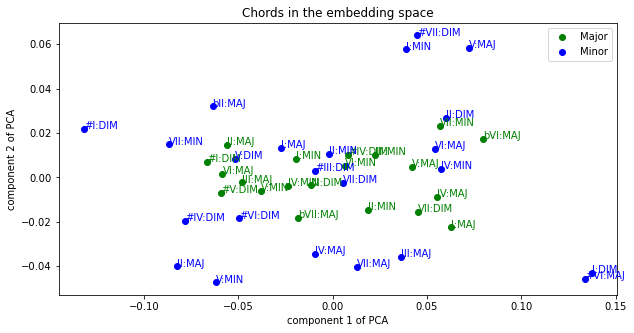

In [69]:
#Visualization
labels_maj = [chord for chord in model_maj.wv.vocab.keys()]
labels_min = [chord for chord in model_min.wv.vocab.keys()]

component1_maj = df_maj['component1'].values
component2_maj = df_maj['component2'].values

component1_min = df_min['component1'].values
component2_min = df_min['component2'].values

plt.figure(figsize=(10,5))
plt.scatter(component1_maj, component2_maj, color = 'green', label ='Major')
plt.scatter(component1_min, component2_min, color = 'blue', label='Minor')
plt.xlabel('component 1 of PCA')
plt.ylabel('component 2 of PCA')
plt.title('Chords in the embedding space')
plt.legend()

for i, chord in enumerate(labels_maj):
    plt.annotate(chord, (component1_maj[i], component2_maj[i]), color='green')
for i, chord in enumerate(labels_min):
    plt.annotate(chord, (component1_min[i], component2_min[i]), color='blue')

For exemple we see that the closer chord to 'I:MAJ' is 'VII:DIM' for the major mode, so it's the same result we had with 'model_maj.most_similarity('I:MAJ')' : Good news, it means PCA works well !!